# Analyze Ceramide Staining Intensity

### Import Modules

In [1]:
# Import packages
import datetime
import os
import glob
import pandas as pd
import numpy as np

# Import plotting packages
import matplotlib as mpl
import seaborn as sns
import dabest

print("matplotlib v{}".format(mpl.__version__))
print("seaborn v{}".format(sns.__version__))
print("dabest v{}".format(dabest.__version__))

matplotlib v3.0.3
seaborn v0.9.0
dabest v0.2.4


/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### Assemble image data into a single dataframe

In [2]:
# Navigate to CSV path
path = os.path.abspath('')+'/IntDen/'
full_df = pd.DataFrame()
list_ = []

for file_ in glob.glob(path + "/*.csv"):         # For loop to bring in files and concatenate them into a single dataframe
    df = pd.read_csv(file_)
    df['Image'] = os.path.splitext(os.path.basename(file_))[0]                      # Determine Image name from file name
    df['Stain'], df['ROI'] = zip(*df['Label'].map(lambda x: x.split(':')))          # Split values in ROI label
    (df['ExptDate'], df['Treatment'], df['Stains'], df['Embryo'],                   # Split values in Image name column
        df['Somites'], df['Section']) = zip(*df['Image'].map(lambda x: x.split('_')))
    list_.append(df)

full_df = pd.concat(list_)
full_df.head()

,,Label,Area,Mean,Min,Max,IntDen,RawIntDen,Image,Stain,ROI,ExptDate,Treatment,Stains,Embryo,Somites,Section
0,1,Cad6B:background,10.254,17.849,9,29,183.031,3552.0,"20190322_SMPD3MO0,8mM_Cad6BSnai2GFPNcad_Emb5_6...",Cad6B,background,20190322,"SMPD3MO0,8mM",Cad6BSnai2GFPNcad,Emb5,6ss,sec1
1,2,Cad6B:background,19.117,17.547,7,32,335.454,6510.0,"20190322_SMPD3MO0,8mM_Cad6BSnai2GFPNcad_Emb5_6...",Cad6B,background,20190322,"SMPD3MO0,8mM",Cad6BSnai2GFPNcad,Emb5,6ss,sec1
2,3,Cad6B:background,15.253,17.524,8,32,267.281,5187.0,"20190322_SMPD3MO0,8mM_Cad6BSnai2GFPNcad_Emb5_6...",Cad6B,background,20190322,"SMPD3MO0,8mM",Cad6BSnai2GFPNcad,Emb5,6ss,sec1
3,4,Cad6B:Cntl,3000.534,77.136,6,8064,231449.924,4491644.0,"20190322_SMPD3MO0,8mM_Cad6BSnai2GFPNcad_Emb5_6...",Cad6B,Cntl,20190322,"SMPD3MO0,8mM",Cad6BSnai2GFPNcad,Emb5,6ss,sec1
4,5,Cad6B:Expt,2416.916,81.235,6,3073,196338.681,3810256.0,"20190322_SMPD3MO0,8mM_Cad6BSnai2GFPNcad_Emb5_6...",Cad6B,Expt,20190322,"SMPD3MO0,8mM",Cad6BSnai2GFPNcad,Emb5,6ss,sec1


In [3]:
# Add experiment date here to apply to dataframe
now = datetime.datetime.now()
analysis_date = now.strftime("%Y%m%d")

# Get a list of treatments and stains
treatment_list = full_df.Treatment.unique()
treatment_list = treatment_list.tolist()
stain_list = full_df.Stain.unique()
stain_list = stain_list.tolist()

# Mean background values and group by Treatment, Embryo, Fluor, ROI and Section
mean_sections = ((full_df.groupby(['Stain', 'Treatment', 'Embryo', 'ROI', 'Section', 'ExptDate'])
                  ['Area', 'Mean', 'IntDen']).mean())

# Loop through stains, performing the following analysis
for j in stain_list:
    stain = j
    df_stain = pd.DataFrame(mean_sections.xs(stain))
    
    # Loop trough treatments, performing each analysis and exporting CSV file for each treatment
    for i in treatment_list:
        # Slice dataframe to process only embryos with given treatment
        treatment = i
        df_treatment = pd.DataFrame(df_stain.xs(treatment))

        # Determine CTCF values = ROI IntDen - (background mean * ROI area)
        # Calculate background (background mean * ROI area)
        background_corr_cntl = (df_treatment.xs('background', level='ROI')['Mean'] 
                        * df_treatment.xs('Cntl', level='ROI')['Area'])
        background_corr_expt = (df_treatment.xs('background', level='ROI')['Mean'] 
                        * df_treatment.xs('Expt', level='ROI')['Area'])

        # Slice out only Cntl or Expt values in IntDen
        intdens_cntl = df_treatment.xs('Cntl', level='ROI')['IntDen'] 
        intdens_expt = df_treatment.xs('Expt', level='ROI')['IntDen'] 

        # Subtract background from IntDens to determine CTCF and concatenate into single dataframe
        sub_cntl = pd.DataFrame(intdens_cntl - background_corr_cntl)
        sub_expt = pd.DataFrame(intdens_expt - background_corr_expt)
        full_ctcf = pd.concat([sub_cntl, sub_expt], keys = ['Cntl', 'Expt'])
        full_ctcf.columns = ['CTCF']

        # Combine raw values, generate ratio
        ctcf_cntl = full_ctcf.xs('Cntl').reset_index()
        ctcf_cntl.rename(columns={'CTCF':'Cntl CTCF'}, inplace=True)
        ctcf_expt = full_ctcf.xs('Expt').reset_index()
        ctcf_expt.rename(columns={'CTCF':'Expt CTCF'}, inplace=True)
        results = pd.concat([ctcf_cntl,ctcf_expt], axis=1)
        results['Expt/Cntl CTCF'] = ctcf_expt['Expt CTCF'] / ctcf_cntl['Cntl CTCF']
        results = results.loc[:,~results.columns.duplicated()]
        results = results.groupby(['Embryo', 'ExptDate']).mean().reset_index()

        # Normalize means

            # Normalize all migration area values to mean of control group
        norm_cntl = pd.DataFrame(results['Cntl CTCF']/(float(results['Cntl CTCF'].mean())))
        norm_cntl.rename(columns={'Cntl CTCF':'Norm Cntl CTCF'}, inplace=True)
        norm_expt = pd.DataFrame(results['Expt CTCF']/(float(results['Cntl CTCF'].mean())))
        norm_expt.rename(columns={'Expt CTCF':'Norm Expt CTCF'}, inplace=True)
        norm_expt.columns = ['Norm Expt CTCF']
        results = pd.concat([results, norm_cntl, norm_expt], axis=1, sort=False)
        results.to_csv(analysis_date + '_' + stain + '_' + treatment + '_Intensity.csv')

In [6]:
results = pd.read_csv('20190722_Cad6B_SMPD3MO0,8mM_Intensity.csv')
results = dabest.load(results, idx=('Norm Cntl CTCF', 'Norm Expt CTCF')
                                ,id_col='Embryo', paired=True)
results.mean_diff.statistical_tests

/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2778: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


,control,test,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_wilcoxon,statistic_wilcoxon,pvalue_paired_students_t,statistic_paired_students_t
0,Norm Cntl CTCF,Norm Expt CTCF,mean difference,True,-0.113543,95,-0.472187,0.13113,0.236724,7.0,0.222439,1.360907


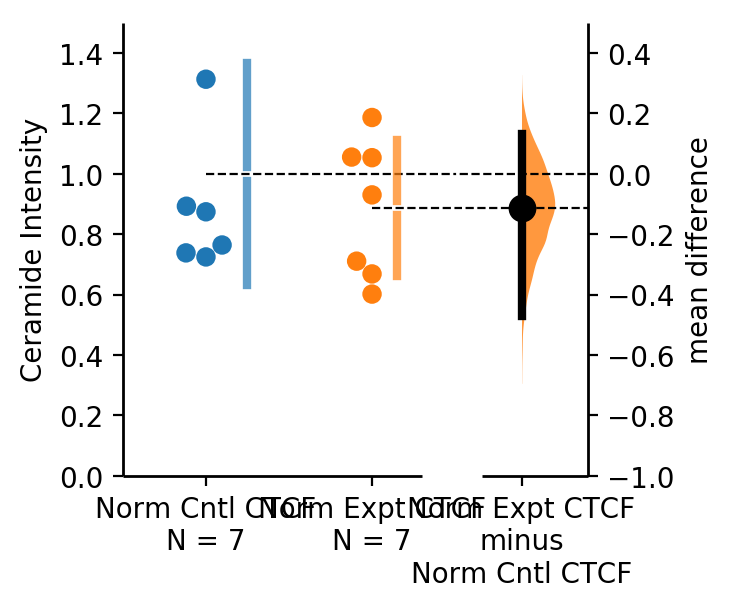

In [7]:
fig1 = results.mean_diff.plot(
    #Set overall figure parameters
                dpi=200
                ,fig_size=(3,3)
    
    #Edit legend features, use matplotlib.Axes.legend kwargs in dictionary format
#                 ,legend_kwargs={'loc':'upper left'
#                                 ,'frameon':True}

    
    #Edit 0 line features, use matplotlib.Axes.hlines kwargs in dictionary format
                ,reflines_kwargs= {'linestyle':'dashed'      
                               ,'linewidth':.8
                               ,'color' : 'black'}
    
    #Set swarm plot parameters    
                ,swarm_label='Ceramide Intensity'
                ,swarm_ylim=(0,1.5)
                ,show_pairs=False                    #connect paired points? Yes (True), no (False)
#                 ,color_col='ID'                   #color points based on defined column identifier
#                 ,custom_palette={'Cntl CTCF':'#747575'
#                                  ,'Expt CTCF':'#139604'}
                ,swarm_desat=1
                ,group_summaries='mean_sd'           #display mean+/-sd as bars next to swarm plots
                ,group_summaries_offset=0.15
    #Edit swarmplot features, use seaborn.swarmplot kwargs in dictionary format
                ,swarmplot_kwargs={'size':7}

    
    #Edit group summary line features, use matplotlib.lines.Line2D kwargs in dictionary format
                ,group_summary_kwargs={'lw':3
                                      ,'alpha':.7}
    #Set effect size plot parameters
                ,float_contrast=True                 #displays mean difference next to graph (True) or below graph (False)
                ,contrast_label='mean difference'
                ,es_marker_size=9 
                ,halfviolin_desat=1
                ,halfviolin_alpha=0.8
    #Edit violin features, use sns.violinplot kwargs in dictionary format
                ,violinplot_kwargs={'widths':0.5}
    
    #Edit legend features, use matplotlib.Axes.legend kwargs in dictionary format
#                 ,legend_kwargs={'loc':'upper left'
#                                 ,'frameon':True}


    #Edit slopegraph features, use 
                    #kwargs in dictionary format
#                 ,slopegraph_kwargs={'color':'blue'}
                             )